## **Heart Disease Prediction**

### Importing and Transforming Dataset

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import category_encoders as ce
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from pylab import rcParams

In [121]:
%matplotlib inline
rcParams['figure.figsize'] = 5,3
rcParams["legend.fontsize"] = 8

warnings.filterwarnings("ignore")

The dataset was taken from <a href="https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease">Personal Key Indicators</a> in Kaggle. It includes risk factors and other key indicators of heart disease such as diabetes, obesity (high BMI), smoking, and alcohol consumption.

In [122]:
heart_disease_df = pd.read_csv('./dataset/Key Indicators of Heart Disease.csv')
heart_disease_df.head(5)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


Prior to training our model, extract only the necessary columns to restrict the data to those that have a substantial influence on heart disease.

In [123]:
heart_disease_df_filtered = heart_disease_df[['HeartDisease', 'Sex', 'AgeCategory', 'Race', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'Diabetic', 'PhysicalActivity', 'GenHealth']]
heart_disease_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   Sex               319795 non-null  object 
 2   AgeCategory       319795 non-null  object 
 3   Race              319795 non-null  object 
 4   BMI               319795 non-null  float64
 5   Smoking           319795 non-null  object 
 6   AlcoholDrinking   319795 non-null  object 
 7   Stroke            319795 non-null  object 
 8   Diabetic          319795 non-null  object 
 9   PhysicalActivity  319795 non-null  object 
 10  GenHealth         319795 non-null  object 
dtypes: float64(1), object(10)
memory usage: 26.8+ MB


Check if there are missing values

In [124]:
heart_disease_df_filtered.isna().sum()

HeartDisease        0
Sex                 0
AgeCategory         0
Race                0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
Diabetic            0
PhysicalActivity    0
GenHealth           0
dtype: int64

### Checking If Target Variable is Binary

The target variable is the `HeartDisease` column, which should have only two distinct values, namely `Yes` and `No`.

<AxesSubplot: xlabel='HeartDisease', ylabel='count'>

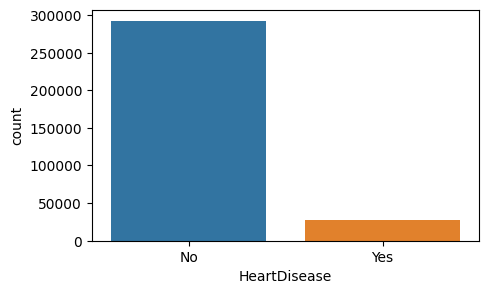

In [125]:
sb.countplot(x='HeartDisease', data=heart_disease_df_filtered)

The chart reveals that there is an imbalance in the number of records for `HeartDisease`, indicating an uneven distribution of data between individuals who have the ailment and those who do not. This could cause the trained model's predictions for heart disease to be severely biased. To balance the class distribution, we will use SMOTE (Synthetic Minority Oversampling Technique). However, before using SMOTE, all categorical data must be transformed into binary using dummy variables for the method to function effectively.

<em>The <b>SMOTE</b> algorithm takes in the closest minority class data entries and creates new combinations based on those entries.<sup>2</sup></em>


### Exploratory Analysis on Feature Variables

View summary statistics of `BMI`

In [126]:
heart_disease_df_filtered.groupby('HeartDisease').describe()

BMI                                                        
                 count       mean       std    min    25%    50%    75%    max
HeartDisease                                                                  
No            292422.0  28.224658  6.325660  12.02  23.89  27.26  31.32  94.85
Yes            27373.0  29.401592  6.577151  12.21  25.06  28.34  32.69  83.33

Data distribution of cases with Yes/No heart disease according to `Sex`

<AxesSubplot: xlabel='Sex', ylabel='count'>

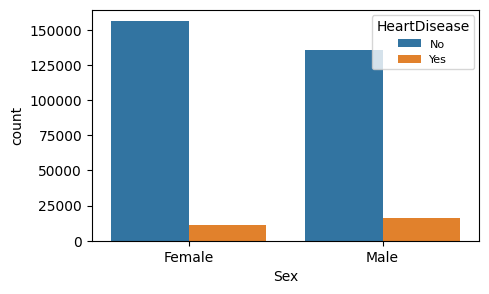

In [127]:
sb.countplot(x= heart_disease_df_filtered['Sex'], hue = 'HeartDisease', data = heart_disease_df_filtered)

Data distribution of cases with Yes/No heart disease according to `AgeCategory`

<AxesSubplot: xlabel='AgeCategory', ylabel='count'>

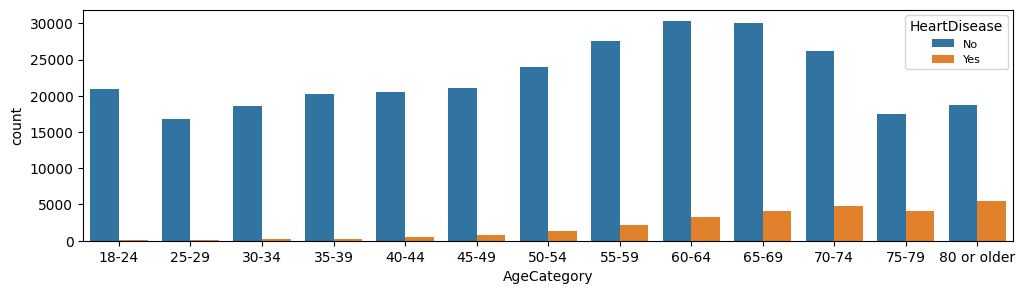

In [128]:
plt.figure(figsize = (12,3))
sb.countplot(x= heart_disease_df_filtered['AgeCategory'].sort_values(ascending=True), hue = 'HeartDisease', data = heart_disease_df_filtered)

Data distribution of cases with Yes/No heart disease according to `Race`

<AxesSubplot: xlabel='Race', ylabel='count'>

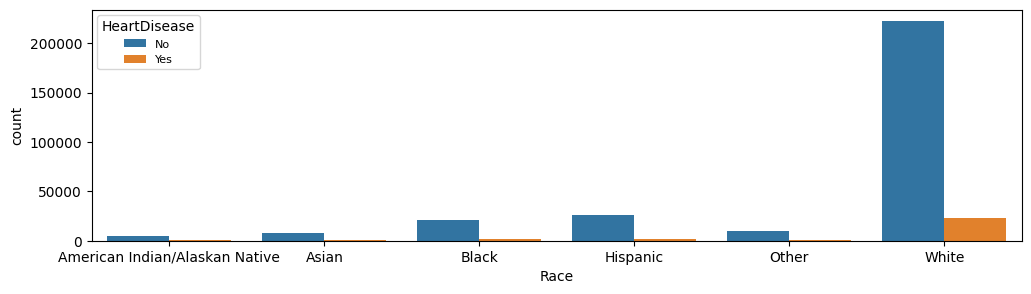

In [129]:
plt.figure(figsize = (12,3))
sb.countplot(x= heart_disease_df_filtered['Race'].sort_values(ascending=True), hue = 'HeartDisease', data = heart_disease_df_filtered)

Data distribution of cases with Yes/No heart disease according to `Smoking`

<AxesSubplot: xlabel='Smoking', ylabel='count'>

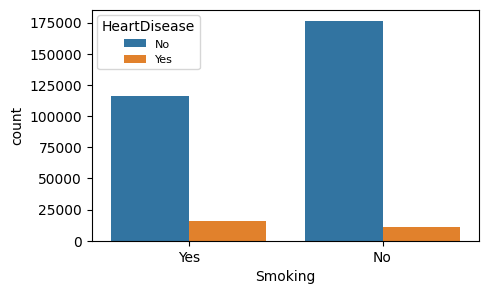

In [130]:
sb.countplot(x= heart_disease_df_filtered['Smoking'], hue = 'HeartDisease', data = heart_disease_df_filtered)

Data distribution of cases with Yes/No heart disease according to `AlcoholDrinking`

<AxesSubplot: xlabel='AlcoholDrinking', ylabel='count'>

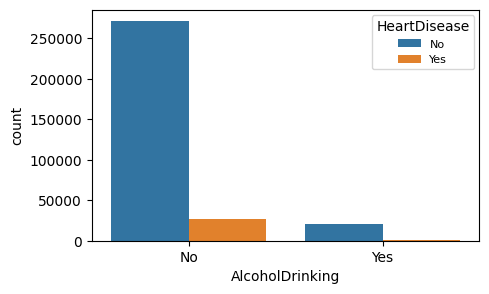

In [131]:
sb.countplot(x= heart_disease_df_filtered['AlcoholDrinking'], hue = 'HeartDisease', data = heart_disease_df_filtered)

Data distribution of cases with Yes/No heart disease according to `Stroke`

<AxesSubplot: xlabel='Stroke', ylabel='count'>

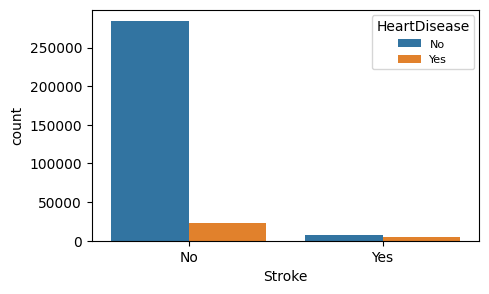

In [132]:
sb.countplot(x= heart_disease_df_filtered['Stroke'], hue = 'HeartDisease', data = heart_disease_df_filtered)

Data distribution of cases with Yes/No heart disease according to `Diabetic`

<AxesSubplot: xlabel='Diabetic', ylabel='count'>

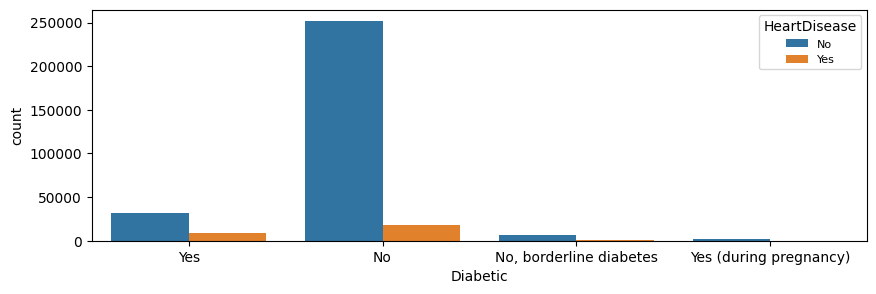

In [133]:
plt.figure(figsize = (10,3))
sb.countplot(x= heart_disease_df_filtered['Diabetic'], hue = 'HeartDisease', data = heart_disease_df_filtered)

Data distribution of cases with Yes/No heart disease according to `PhysicalActivity`

<AxesSubplot: xlabel='PhysicalActivity', ylabel='count'>

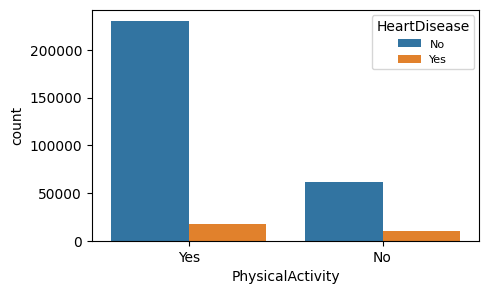

In [134]:
sb.countplot(x= heart_disease_df_filtered['PhysicalActivity'], hue = 'HeartDisease', data = heart_disease_df_filtered)

Data distribution of cases with Yes/No heart disease according to `GenHealth`

<AxesSubplot: xlabel='GenHealth', ylabel='count'>

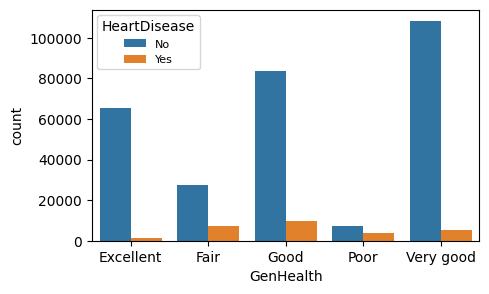

In [135]:
sb.countplot(x= heart_disease_df_filtered['GenHealth'].sort_values(ascending=True), hue = 'HeartDisease', data = heart_disease_df_filtered)

__Observations:__
- The frequency of heart disease cases is directly proportional with the age of the individuals, which is expected.
- A larger number of individuals of White group are experiencing heart disease. Need more variation on the race.
- Insufficient data is available to confirm Alcohol Drinking as a significant indicator of heart disease. 


### Converting Categorical Features to Dummy Indicators

Get all categorical features

In [136]:
categorical_columns = [name for name in heart_disease_df_filtered.columns if heart_disease_df_filtered[name].dtype=='O']

print(f'There are {len(categorical_columns)} categorical features:\n')
print(", ".join(categorical_columns))

There are 10 categorical features:

HeartDisease, Sex, AgeCategory, Race, Smoking, AlcoholDrinking, Stroke, Diabetic, PhysicalActivity, GenHealth


Transform all categorical attributes into binary dummy variables where the value is 0 (representing No) or 1 (representing Yes).

In [137]:
categorical_drop_first = [name for name in categorical_columns if name not in ['AgeCategory', 'Race', 'GenHealth']]
categorical_no_drop = [name for name in categorical_columns if name in ['AgeCategory', 'Race', 'GenHealth']]

heart_disease_df_dummy = pd.get_dummies(data=heart_disease_df_filtered, columns=categorical_drop_first, drop_first=True)
heart_disease_df_dummy = pd.get_dummies(data=heart_disease_df_dummy, columns=categorical_no_drop)
heart_disease_df_dummy.head(5)

,BMI,HeartDisease_Yes,Sex_Male,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_Yes,...,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,16.60,0,0,1,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,1
1,20.34,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,26.58,0,1,1,0,0,0,1,0,1,...,0,0,0,0,1,0,1,0,0,0
3,24.21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,23.71,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1


After the conversion, the target features have expanded from the original 11 columns to a total of 34 columns.

In [138]:
heart_disease_df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 34 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   BMI                                  319795 non-null  float64
 1   HeartDisease_Yes                     319795 non-null  uint8  
 2   Sex_Male                             319795 non-null  uint8  
 3   Smoking_Yes                          319795 non-null  uint8  
 4   AlcoholDrinking_Yes                  319795 non-null  uint8  
 5   Stroke_Yes                           319795 non-null  uint8  
 6   Diabetic_No, borderline diabetes     319795 non-null  uint8  
 7   Diabetic_Yes                         319795 non-null  uint8  
 8   Diabetic_Yes (during pregnancy)      319795 non-null  uint8  
 9   PhysicalActivity_Yes                 319795 non-null  uint8  
 10  AgeCategory_18-24                    319795 non-null  uint8  
 11  AgeCategory_2

### Hyperparameter Tuning for k-Nearest Neighbors

Find the best value for k which will be used for SMOTE's k-nearest neighbors when generating synthetic samples.

In [176]:
X_features = heart_disease_df_dummy.drop(['HeartDisease_Yes'], axis=1)
y_target = heart_disease_df_dummy['HeartDisease_Yes']

param_grid = {'n_neighbors': [55, 60]}

# Create a k-nearest neighbors classifier
knn = KNeighborsClassifier()

# Use grid search to find the optimal value of k
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_features, y_target)

# Print the best parameter and score
print(f"Best parameter: {grid_search.best_params_}")
print(f"Best score: {round(grid_search.best_score_, 2)}")

Best parameter: {'n_neighbors': 55}
Best score: 0.92


### Creating Synthetic Data using SMOTE

Synthetic data will be generated using SMOTE, as previously stated, to achieve a balanced distribution of data across all classes. We will use 55 as value for `k_neighbors` as this yielded the highest score on hyperparameter tuning for k-nearest neighbors.

In [179]:
oversample = SMOTE(k_neighbors=55)

The original count of 27,373 records for the 'with Heart Disease' class has now been balanced with the 'without Heart Disease' class, resulting in a total of 292,422 records for both classes

In [180]:
X_features_smoted, y_target_smoted = oversample.fit_resample(X_features, y_target)
y_target_smoted = pd.Series(y_target_smoted)

print(f'Before using SMOTE\n{y_target.value_counts()}\n')
print(f'After using SMOTE\n{y_target_smoted.value_counts()}')

Before using SMOTE
0    292422
1     27373
Name: HeartDisease_Yes, dtype: int64

After using SMOTE
0    292422
1    292422
Name: HeartDisease_Yes, dtype: int64


### Splitting Data into Training and Test Set

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X_features_smoted, y_target_smoted, test_size=0.3, random_state=500)

print(f"No. of train datasets: x={X_train.shape} y={y_train.shape}")
print(f"No. of test datasets: x={X_test.shape} y={y_test.shape}\n")

No. of train datasets: x=(409390, 33) y=(409390,)
No. of test datasets: x=(175454, 33) y=(175454,)



### Creating a Model

A logistic regression model is used to predict Heart Disease, with 70% of the dataset allocated for training the model.

In [182]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)
print(f"Model type: {model}")

Model type: LogisticRegression()


### Checking for Overfitting and Underfitting

The accuracy score for the training set is 0.8334 and for the test set it is 0.8349, which are very similar. Therefore, there is no evidence of overfitting.

In [183]:
# Evaluate model on training dataset
train_accuracy = accuracy_score(y_train, model.predict(X_train))
print("Training Accuracy:", round(train_accuracy, 4))

# Evaluate model on testing dataset
test_accuracy = accuracy_score(y_test, model.predict(X_test))
print("Testing Accuracy:", round(test_accuracy, 4))

Training Accuracy: 0.8334
Testing Accuracy: 0.8349


### Evaluating the Model

We will use classification report and confusion matrix to view the summary of prediction results and to give us a clear picture of classification model performance.

Classification Report

              precision    recall  f1-score   support

           0       0.85      0.82      0.83     87792
           1       0.82      0.85      0.84     87662

    accuracy                           0.83    175454
   macro avg       0.84      0.83      0.83    175454
weighted avg       0.84      0.83      0.83    175454



Text(0.5, 1.0, 'Confusion Matrix')

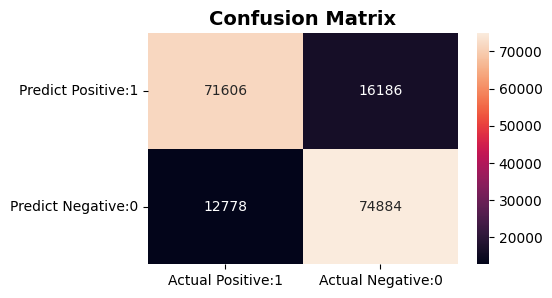

In [203]:
y_pred_test = model.predict(X_test)

print("Classification Report\n")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
TN, FP, FN, TP = cm.ravel()

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sb.heatmap(cm_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')

The created model has an <b>accuracy score of 0.8349</b>, indicating the number of accurate predictions relative to the total number of predictions.

In [197]:
accuracy_score_s = (TP + TN) / float(TP + TN + FP + FN)   # OR accuracy_score(y_test_smore, y_pred_test)
print(f'Accuracy score: {round(accuracy_score_s, 4)}')

Accuracy score: 0.8349


It has a <b>precision score of 0.8223</b>, representing the number of positive predictions that are accurate compared to the total number of predicted positives.

In [198]:
precision_score_s = TP / float(TP + FP)   # OR precision_score(y_test_smore, y_pred_test)
print(f'Precision score: {round(precision_score_s, 4)}')

Precision score: 0.8223


Its <b>recall score is 0.8542</b>, indicating the proportion of actual positive cases that are correctly identified by the model out of all positive cases.

In [199]:
recall_score_s = TP / float(TP + FN)  # OR recall_score(y_test_smore, y_pred_test)
print(f'Recall score: {round(recall_score_s, 4)}')

Recall score: 0.8542


The ROC (Receiver Operating Characteristics) curve shown below is well-balanced, with an AUC (Area Under the Curve) score of 0.9219, indicating a good level of distinction between the model's ability to predict heart disease or not (a perfect classifier would have an AUC of 1.). We can say that the model performs well in predicting heart disease.

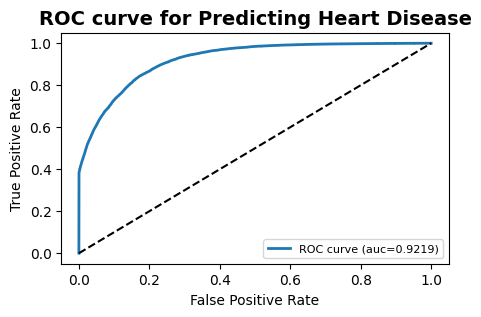

In [200]:
y_prob_test = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

auc = round(roc_auc_score(y_test, y_prob_test), 4)

plt.plot(fpr, tpr, linewidth=2, label="ROC curve (auc=" + str(auc) + ")")
plt.plot([0,1], [0,1], 'k--' )
plt.title('ROC curve for Predicting Heart Disease', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Comparing Evaluation Metrics (with and without using SMOTE)

Generate a new model using the non-SMOTE dataset then assess the performance of this model.

Classification Report

              precision    recall  f1-score   support

           0       0.96      0.81      0.88     87886
           1       0.23      0.60      0.33      8053

    accuracy                           0.80     95939
   macro avg       0.59      0.71      0.60     95939
weighted avg       0.90      0.80      0.83     95939



Text(0.5, 1.0, 'Confusion Matrix')

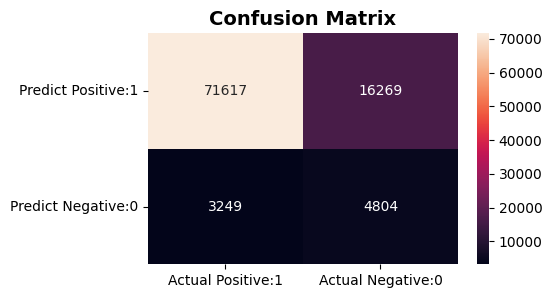

In [189]:
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X_features, y_target, test_size=0.3, random_state=500)

model_ns = LogisticRegression(solver='lbfgs')
model_ns.fit(X_train_ns, y_train_ns)

y_pred_test_ns = model.predict(X_test_ns)

print("Classification Report\n")
print(classification_report(y_test_ns, y_pred_test_ns))

cm_ns = confusion_matrix(y_test_ns, y_pred_test_ns)
cm_matrix_n = pd.DataFrame(data=cm_ns, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sb.heatmap(cm_matrix_n, annot=True, fmt='d')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')

Get the accuracy, precision, recall and auc scores for non-SMOTE model

In [201]:
accuracy_score_ns = accuracy_score(y_test_ns, y_pred_test_ns)
precision_score_ns = precision_score(y_test_ns, y_pred_test_ns)
recall_score_ns = recall_score(y_test_ns, y_pred_test_ns)

y_prob_test_ns = model.predict_proba(X_test_ns)[:,1]
auc_ns = round(roc_auc_score(y_test_ns, y_prob_test_ns), 4)

Plot in the graph the accuracy, precision, recall and auc scores to compare prediction performance of SMOTE and non-SMOTE models

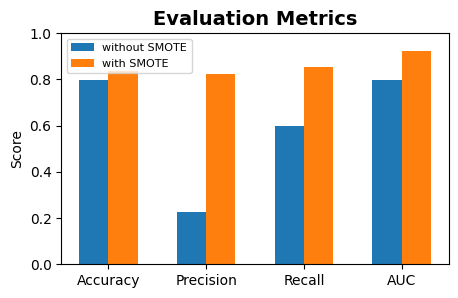

In [202]:
fig, (ax1) = plt.subplots(1)

labels = ['Accuracy', 'Precision', 'Recall', 'AUC']
ns_score = [accuracy_score_ns, precision_score_ns, recall_score_ns, auc_ns]
s_score = [accuracy_score_s, precision_score_s, recall_score_s, auc]

barWidth = 0.3
x = np.arange(len(ns_score)) # Set position of bar on X axis

ax1.bar(x - barWidth/2, ns_score, width=barWidth, label='without SMOTE')
ax1.bar(x + barWidth/2, s_score, width=barWidth, label='with SMOTE')

ax1.set_xticks(x, labels)
ax1.set_ylabel('Score')
ax1.set_ylim(0, 1)
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

plt.show()

__Explanation:__
The graph shows the non-SMOTE model has a considerably low precision score with 0.23, implying that only a small proportion of its positive predictions are accurate. This outcome can be attributed to the imbalanced distribution of the dataset among its classes, which severely skewed the model's precision. Additionally, all other non-SMOTE metrics display inferior scores. From this, it can be concluded that using SMOTE to balance the dataset has greatly improved the performance of our model.

### Make Test Prediction

We will evaluate our model, which employed SMOTE, by utilizing it to estimate the likelihood of a patient developing heart disease based on the patient's profile provided below.

In [192]:
from enum import Enum

class Field(Enum):

    BMI = 0
    Sex = 1
    Smoking = 2
    AlcoholDrinking = 3
    Stroke = 4
    DiabeticBorderline = 5
    Diabetic = 6
    DiabeticPregnancy= 7
    PhysicalActivity = 8
    AgeCategory_18_24 = 9  
    AgeCategory_25_29 = 10
    AgeCategory_30_34 = 11
    AgeCategory_35_39 = 12
    AgeCategory_40_44 = 13
    AgeCategory_45_49 = 14
    AgeCategory_50_54 = 15
    AgeCategory_55_59 = 16
    AgeCategory_60_64 = 17
    AgeCategory_65_69 = 18
    AgeCategory_70_74 = 19
    AgeCategory_75_79 = 20
    AgeCategory_80_older = 21
    Race_American_Indian = 22
    Race_Asian = 23
    Race_Black = 24
    Race_Hispanic = 25
    Race_Other = 26
    Race_White = 27
    GenHealth_Excellent = 28
    GenHealth_Fair = 29
    GenHealth_Good = 30
    GenHealth_Poor = 31
    GenHealth_Very_Good = 32


def getPrediction(input_data, model):
    df = np.array(input_data).reshape(1,-1)
    return round(model.predict_proba(df)[0][1] * 100, 2)


def testPrediction(input_data, model):

    print("-----------------------------------------------------------")
    print("                   PATIENT'S RECORD                        ")
    print("-----------------------------------------------------------")
    for key, value in input_data.items():
        print(f"{key}: {value}")
    print("-----------------------------------------------------------")
    
    upd_input_data = [0] * (heart_disease_df_dummy.columns.size - 1)

    upd_input_data[Field.BMI.value] = input_data['BMI']
    upd_input_data[Field.Sex.value] = 1 if input_data['Sex'].lower()  == 'male' else 0
    upd_input_data[Field.AlcoholDrinking.value] = 1 if input_data['Alcohol Drinking'].lower() == 'yes' else 0
    upd_input_data[Field.PhysicalActivity.value] = 1 if input_data['Physical Activity'].lower()  == 'yes' else 0
    upd_input_data[Field.Smoking.value] = 1 if input_data['Smoking'].lower()  == 'yes' else 0
    upd_input_data[Field.Stroke.value] = 1 if input_data['Stroke'].lower()  == 'yes' else 0
    

    race = input_data['Race'].lower()
    if race in ['american indian', 'alaskan native']:
        upd_input_data[Field.Race_American_Indian.value] = 1
    elif race == 'asian':
        upd_input_data[Field.Race_Asian.value] = 1
    elif race == 'black':
        upd_input_data[Field.Race_Black.value] = 1
    elif race == 'hispanic':
        upd_input_data[Field.Race_Hispanic.value] = 1
    elif race == 'white':
        upd_input_data[Field.Race_White.value] = 1
    elif race == 'other':
        upd_input_data[Field.Race_Other.value] = 1

    
    age = input_data['Age']
    if 18 >= age <= 24:
        upd_input_data[Field.AgeCategory_18_24.value] = 1
    elif 25 >= age <= 29:
        upd_input_data[Field.AgeCategory_25_29.value] = 1
    elif 30 >= age <= 34:
        upd_input_data[Field.AgeCategory_30_34.value] = 1
    elif 35 >= age <= 39:
        upd_input_data[Field.AgeCategory_35_39.value] = 1
    elif 40 >= age <= 44:
        upd_input_data[Field.AgeCategory_40_44.value] = 1
    elif 45 >= age <= 49:
        upd_input_data[Field.AgeCategory_45_49.value] = 1
    elif 50 >= age <= 54:
        upd_input_data[Field.AgeCategory_50_54.value] = 1
    elif 55 >= age <= 59:
        upd_input_data[Field.AgeCategory_55_59.value] = 1
    elif 60 >= age <= 64:
        upd_input_data[Field.AgeCategory_60_64.value] = 1
    elif 65 >= age <= 69:
        upd_input_data[Field.AgeCategory_65_69.value] = 1
    elif 70 >= age <= 74:
        upd_input_data[Field.AgeCategory_70_74.value] = 1
    elif 75 >= age <= 79:
        upd_input_data[Field.AgeCategory_75_79.value] = 1
    elif age >= 80:
        upd_input_data[Field.AgeCategory_80_older.value] = 1


    diabetic = input_data['Diabetic'].lower()
    if diabetic  == 'yes':
        upd_input_data[Field.Diabetic.value] = 1
    elif diabetic.endswith("borderline"):
        upd_input_data[Field.DiabeticBorderline.value] = 1
    elif diabetic.endswith("during pregnancy"):
        upd_input_data[Field.DiabeticPregnancy.value] = 1
    

    general_health = input_data['General Health'].lower()
    if general_health == 'poor':
        upd_input_data[Field.GenHealth_Poor.value] = 1
    elif general_health == 'fair':
        upd_input_data[Field.GenHealth_Fair.value] = 1
    elif general_health == 'good':
        upd_input_data[Field.GenHealth_Good.value] = 1
    elif general_health == 'very good':
        upd_input_data[Field.GenHealth_Very_Good.value] = 1
    elif general_health == 'excellent':
        upd_input_data[Field.GenHealth_Excellent.value] = 1


    prediction = getPrediction(upd_input_data, model)
    print(f"\nThe probability of {input_data['Name']} to get heart disease is {prediction}%")


__Test data #1__

In [193]:
input_data = {
    'Name' : 'Gino Cruz',
    'Sex' : 'Male',
    'Age' : 25,
    'Race' : 'Black',
    'BMI' : 21.6,
    'Smoking' : 'Yes',
    'Alcohol Drinking' : 'No',
    'Stroke' : 'No',
    'Diabetic' : 'No',
    'Physical Activity' : 'Yes',
    'General Health' : 'Poor'
}

testPrediction(input_data, model)

-----------------------------------------------------------
                   PATIENT'S RECORD                        
-----------------------------------------------------------
Name: Gino Cruz
Sex: Male
Age: 25
Race: Black
BMI: 21.6
Smoking: Yes
Alcohol Drinking: No
Stroke: No
Diabetic: No
Physical Activity: Yes
General Health: Poor
-----------------------------------------------------------

The probability of Gino Cruz to get heart disease is 1.37%


__Test data #2__

In [194]:
input_data = {
    'Name' : 'Nicole Santos',
    'Sex' : 'Female',
    'Age' : 40,
    'Race' : 'White',
    'BMI' : 94.6,
    'Smoking' : 'Yes',
    'Alcohol Drinking' : 'No',
    'Stroke' : 'No',
    'Diabetic' : 'Yes, during pregnancy',
    'Physical Activity' : 'Yes',
    'General Health' : 'Poor'
}

testPrediction(input_data, model)

-----------------------------------------------------------
                   PATIENT'S RECORD                        
-----------------------------------------------------------
Name: Nicole Santos
Sex: Female
Age: 40
Race: White
BMI: 94.6
Smoking: Yes
Alcohol Drinking: No
Stroke: No
Diabetic: Yes, during pregnancy
Physical Activity: Yes
General Health: Poor
-----------------------------------------------------------

The probability of Nicole Santos to get heart disease is 9.54%


__Test data #3__

In [195]:
input_data = {
    'Name' : 'Alfred Gomez',
    'Sex' : 'Male',
    'Age' : 60,
    'Race' : 'White',
    'BMI' : 94.6,
    'Smoking' : 'Yes',
    'Alcohol Drinking' : 'Yes',
    'Stroke' : 'No',
    'Diabetic' : 'Yes',
    'Physical Activity' : 'No',
    'General Health' : 'Poor'
}

testPrediction(input_data, model)

-----------------------------------------------------------
                   PATIENT'S RECORD                        
-----------------------------------------------------------
Name: Alfred Gomez
Sex: Male
Age: 60
Race: White
BMI: 94.6
Smoking: Yes
Alcohol Drinking: Yes
Stroke: No
Diabetic: Yes
Physical Activity: No
General Health: Poor
-----------------------------------------------------------

The probability of Alfred Gomez to get heart disease is 68.47%


__Test data #4__

In [196]:
input_data = {
    'Name' : 'Erika de Leon',
    'Sex' : 'Female',
    'Age' : 80,
    'Race' : 'Hispanic',
    'BMI' : 94.6,
    'Smoking' : 'Yes',
    'Alcohol Drinking' : 'Yes',
    'Stroke' : 'Yes',
    'Diabetic' : 'Yes',
    'Physical Activity' : 'No',
    'General Health' : 'Poor'
}

testPrediction(input_data, model)

-----------------------------------------------------------
                   PATIENT'S RECORD                        
-----------------------------------------------------------
Name: Erika de Leon
Sex: Female
Age: 80
Race: Hispanic
BMI: 94.6
Smoking: Yes
Alcohol Drinking: Yes
Stroke: Yes
Diabetic: Yes
Physical Activity: No
General Health: Poor
-----------------------------------------------------------

The probability of Erika de Leon to get heart disease is 50.02%


### Conclusions

- A Logistic Regression algorithm has been used to train and test a model that can anticipate the probability of heart disease based on key indicators. The model yields accuracy, precision, and recall scores of 0.81, 0.78, and 0.86, respectively, which are indicative of a sound classification performance.
- Using SMOTE to generate synthetic data has substantially improved the precision of the model. This technique is essential if the distribution of data among various classes is highly skewed. However, additional analysis and testing is still necessary. Having more data on individuals with heart disease is much better to improve the accuracy and precision of the model.
- The accuracy score for the training set is 0.8334 and for the test set it is 0.8349, which are very similar. Therefore, there is no evidence of overfitting.
- With an ROC AUC value of 0.90, we can infer that our classifier performs excellently in predicting whether an individual has heart disease.

### References

1. https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease
2. https://medium.com/geekculture/how-to-deal-with-class-imbalances-in-python-960908fe0425
3. https://medium.com/analytics-vidhya/what-is-a-confusion-matrix-d1c0f8feda5#:~:text=2.-,Classification%20Measure,our%20model%20and%20its%20performance.
4. https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62
5. https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

> AML-2203 Winter 2023 Mid-Term Project (Group 7)